# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First Import it using pandas

In [7]:

raw_dataset = pd.read_csv("./data/fromStateToAction_df (28).csv")

dataset = raw_dataset.copy()


We need all the path to have the same steps. Therefore we will trunk the path to the same lenght and omit those with reduced lenght

First we check with is the most common lenght

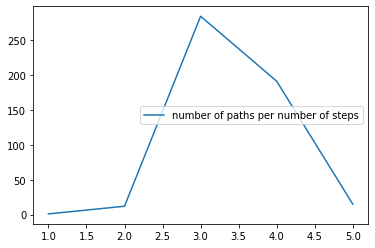

In [8]:
len_stat = dataset.groupby(["id_camino"]).size().reset_index(name='counts')
plt.plot(len_stat.groupby(["counts"]).size(), label ="number of paths per number of steps")
plt.legend()

We will cut at CUT_STEP steps (n=CUT_STEP+1) and remove the path with less than CUT_STEP

In [9]:
N_STEPS= 3

long_paths = len_stat[len_stat.counts>N_STEPS]
red_dataset = dataset.loc[dataset["id_camino"].isin(long_paths["id_camino"])]
reg_dataset= red_dataset[red_dataset.id_in_seq< (N_STEPS+1)] 
reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
6,2,0,"[0, 0, 1, 0, 0, 0]","[2054.788057485821, -473.805282793441, 2.01175...",19,378.414697
7,2,1,"[535.3258304576225, -13.417216627478174, 1.246...","[2054.788057485821, -473.805282793441, 2.01175...",14,378.414697
8,2,2,"[735.1689638300827, -204.85627327125425, 5.124...","[2054.788057485821, -473.805282793441, 2.01175...",1,378.414697
9,2,3,"[1749.2690747621555, -449.66421198295507, 2.45...","[2054.788057485821, -473.805282793441, 2.01175...",2,378.414697
16,5,0,"[0, 0, 1, 0, 0, 0]","[1754.470919352298, -394.87716251079485, 1.230...",20,378.414697


Finaly, the new goal state is the last state of each path
goal state = Path[4] 

In [10]:
for id in reg_dataset["id_camino"]:
     dummy = "a"
     dummy = reg_dataset.loc[(reg_dataset["id_camino"] == id) & (reg_dataset["id_in_seq"] == 4)].current_state
     for index in reg_dataset[reg_dataset["id_camino"] == id]:
         reg_dataset["goal_state"][index] = dummy

reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
6,2,0,"[0, 0, 1, 0, 0, 0]","[2054.788057485821, -473.805282793441, 2.01175...",19,378.414697
7,2,1,"[535.3258304576225, -13.417216627478174, 1.246...","[2054.788057485821, -473.805282793441, 2.01175...",14,378.414697
8,2,2,"[735.1689638300827, -204.85627327125425, 5.124...","[2054.788057485821, -473.805282793441, 2.01175...",1,378.414697
9,2,3,"[1749.2690747621555, -449.66421198295507, 2.45...","[2054.788057485821, -473.805282793441, 2.01175...",2,378.414697
16,5,0,"[0, 0, 1, 0, 0, 0]","[1754.470919352298, -394.87716251079485, 1.230...",20,378.414697


In [11]:
N_CATEGORIES = 28

dataset = reg_dataset

for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["out_action"][index] = int(dataset["out_action"][index])

# Usar estado final 
dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


In [12]:
dataset[0:10]

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps,Difference,C0,C1,C2,C3,C4,C5,D0,D1,D2,D3,D4,D5
6,2,0,"[0, 0, 1, 0, 0, 0]","[2054.788057485821, -473.805282793441, 2.01175...",19,378.414697,"[2054.788057485821, -473.805282793441, 1.01175...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2054.788057,-473.805283,1.011759,0.115715,-0.121895,0.003119
7,2,1,"[535.3258304576225, -13.417216627478174, 1.246...","[2054.788057485821, -473.805282793441, 2.01175...",14,378.414697,"[1519.4622270281984, -460.3880661659628, 0.765...",535.325830,-13.417217,1.246710,0.244147,0.425695,-0.052321,1519.462227,-460.388066,0.765048,-0.128431,-0.547590,0.055440
8,2,2,"[735.1689638300827, -204.85627327125425, 5.124...","[2054.788057485821, -473.805282793441, 2.01175...",1,378.414697,"[1319.6190936557382, -268.94900952218677, -3.1...",735.168964,-204.856273,5.124617,0.176976,-0.996700,-0.070930,1319.619094,-268.949010,-3.112859,-0.061260,0.874805,0.074049
9,2,3,"[1749.2690747621555, -449.66421198295507, 2.45...","[2054.788057485821, -473.805282793441, 2.01175...",2,378.414697,"[305.51898272366543, -24.141070810485928, -0.4...",1749.269075,-449.664212,2.454807,0.087096,-0.072580,0.000157,305.518983,-24.141071,-0.443049,0.028619,-0.049315,0.002962
16,5,0,"[0, 0, 1, 0, 0, 0]","[1754.470919352298, -394.87716251079485, 1.230...",20,378.414697,"[1754.470919352298, -394.87716251079485, 0.230...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1754.470919,-394.877163,0.230951,0.119215,0.195719,-0.009906
17,5,1,"[475.7263505971204, -23.4968915086083, 0.88359...","[1754.470919352298, -394.87716251079485, 1.230...",7,378.414697,"[1278.7445687551776, -371.38027100218653, 0.34...",475.726351,-23.496892,0.883599,0.285846,0.011801,-0.069445,1278.744569,-371.380271,0.347352,-0.166631,0.183918,0.059539
18,5,2,"[597.6863090247822, -164.89824203610226, 4.362...","[1754.470919352298, -394.87716251079485, 1.230...",1,378.414697,"[1156.784610327516, -229.9789204746926, -3.131...",597.686309,-164.898242,4.362081,0.144883,-1.008238,-0.057335,1156.784610,-229.978920,-3.131130,-0.025668,1.203957,0.047429
19,5,3,"[1598.689041513774, -422.5234688966301, 2.5023...","[1754.470919352298, -394.87716251079485, 1.230...",10,378.414697,"[155.781877838524, 27.64630638583526, -1.27138...",1598.689042,-422.523469,2.502337,0.086512,-0.085743,0.000531,155.781878,27.646306,-1.271386,0.032702,0.281461,-0.010438
26,8,0,"[0, 0, 1, 0, 0, 0]","[1632.1453074795904, -133.09423807360199, 1.28...",4,378.414697,"[1632.1453074795904, -133.09423807360199, 0.28...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1632.145307,-133.094238,0.289825,0.125367,0.221066,-0.011412
27,8,1,"[495.67843612849117, -49.49751656684203, 1.308...","[1632.1453074795904, -133.09423807360199, 1.28...",6,378.414697,"[1136.4668713510991, -83.59672150675996, -0.01...",495.678436,-49.497517,1.308185,0.164208,0.062300,0.000013,1136.466871,-83.596722,-0.018360,-0.038841,0.158766,-0.011425


### Clean the data

We keep the columns we are interested in 

In [13]:
dataset  = dataset[["D0",'D1',"D2","D3",'D4',"D5","out_action"]]


## Normalize the data

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [14]:
data_stats = dataset.describe()
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
D0,824.0,1148.152474,614.484582,90.648131,624.123244,1268.396610,1624.294354,2073.121403
D1,824.0,-189.201238,172.230608,-601.228635,-342.186037,-124.697157,-42.786864,55.012433
D2,824.0,-0.247820,1.269170,-4.482067,-0.497959,0.027080,0.357537,2.816534
D3,824.0,0.019601,0.105676,-0.246410,-0.057128,0.012525,0.087927,0.289271
D4,824.0,0.081672,0.395350,-0.888360,-0.118746,0.010886,0.187527,1.505748
D5,824.0,0.011270,0.034513,-0.083076,-0.003165,0.000661,0.035833,0.123752
out_action,824.0,7.427184,6.329513,0.000000,3.000000,5.000000,10.250000,27.000000


In [15]:
def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(dataset, data_stats)
normed_data.pop("out_action")
normed_dataset = normed_data.join(dataset["out_action"])


In [78]:
normed_dataset

,D0,D1,D2,D3,D4,D5,out_action
0,1.291553,-2.312238,1.866667,0.106519,-0.383529,-0.082414,12
1,0.415932,-2.106294,1.658680,-2.045003,-0.492249,0.573815,7
2,0.036620,-0.849023,-1.197408,-0.809825,0.215723,0.415310,1
3,-1.665149,0.586682,0.764937,-0.677284,-0.341153,-0.086333,0
16,1.088797,-1.968814,1.888069,0.101816,-0.388895,-0.080897,13
...,...,...,...,...,...,...,...
2692,-0.965107,-0.195893,1.010672,-0.152036,0.080290,0.320987,7
2704,1.423309,-0.616782,0.520740,1.328001,-0.040202,0.117099,2
2705,0.300123,-0.075346,0.003339,0.227299,-0.026047,0.141303,1
2706,-1.177222,0.982734,-0.585876,0.550307,0.056452,0.111046,25


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [16]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [17]:
dataset2 = normed_dataset.values

In [18]:
dataset2.shape

(824, 7)

In [19]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
single_step=True

x_train_single, y_train_single = multivariate_data(dataset2, dataset2[:, 6], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step)
x_val_single, y_val_single = multivariate_data(dataset2, dataset2[:, 6],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step)

In [21]:
x_train_single[0]

array([[ 1.47544073, -1.65245916,  0.99244287,  0.90951923, -0.51490345,
        -0.23618488, 19.        ],
       [ 0.60426211, -1.57455653,  0.79805582, -1.40080978, -1.59165943,
         1.27982293, 14.        ],
       [ 0.27904137, -0.46302903, -2.25741174, -0.76517928,  2.00615805,
         1.8189951 ,  1.        ]])

In [22]:
y_train_single[0]

2.0

In [23]:
training_size = len(x_train_single)
training_size

164

In [24]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (3, 7)


## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [140]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [144]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(N_CATEGORIES,return_sequences=False, input_shape=x_train_single.shape[-2:], ))
single_step_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation="softmax"))

single_step_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [145]:
single_step_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 28)                4032      
_________________________________________________________________
dense_8 (Dense)              (None, 28)                812       
Total params: 4,844
Trainable params: 4,844
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of BATCH_SIZE examples from the training data and call `model.predict` on it.

In [146]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)


(20, 28)


In [93]:
BATCH_SIZE

20

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [147]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 100

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 8.2 steps, validate for 50 steps
Epoch 1/100
9/8 [================================] - 6s 613ms/step - loss: 3.3321 - accuracy: 0.0122 - val_loss: 3.3340 - val_accuracy: 0.0244
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 3.3266 - accuracy: 0.0000e+9/8 [================================] - 0s 20ms/step - loss: 3.3288 - accuracy: 0.0305 - val_loss: 3.3310 - val_accuracy: 0.0244
Epoch 3/100
9/8 [================================] - 0s 26ms/step - loss: 3.3256 - accuracy: 0.0976 - val_loss: 3.3277 - val_accuracy: 0.0244
Epoch 4/100
9/8 [================================] - 0s 19ms/step - loss: 3.3220 - accuracy: 0.0915 - val_loss: 3.3240 - val_accuracy: 0.0244
Epoch 5/100
9/8 [================================] - 0s 18ms/step - loss: 3.3178 - accuracy: 0.1037 - val_loss: 3.3196 - val_accuracy: 0.0244
Epoch 6/100
9/8 [================================] - 0s 18ms/step - loss: 3.3126 - accuracy: 0.1098 - val_loss: 3.3139 - val_accuracy: 0.0000e+00
Epoch 7/100
9/8 [=

In [153]:
test_loss, test_acc = single_step_model.evaluate(x_val_single,  y_val_single, verbose=2)

print('\nTest accuracy:', test_acc)

41/41 - 1s - loss: 3.1917 - accuracy: 0.1951

Test accuracy: 0.19512194


Visualize the model's training progress.

In [30]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

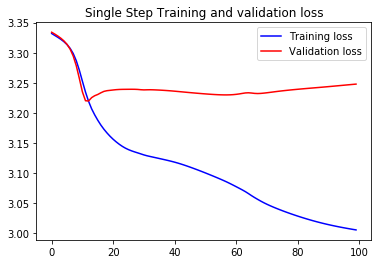

In [148]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## Predict a single step future

In [32]:
probability_model = tf.keras.Sequential([single_step_model, 
                                         tf.keras.layers.Softmax()])

In [149]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [150]:
def create_time_steps(length):
  return list(range(-length, 0))

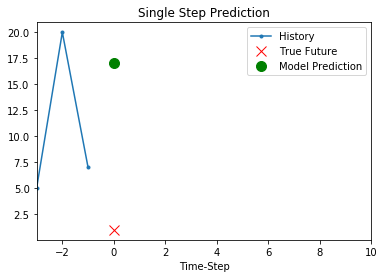

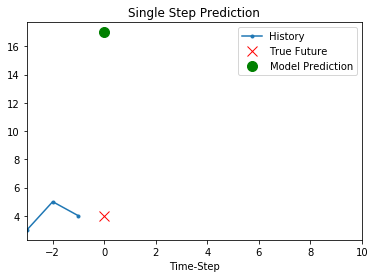

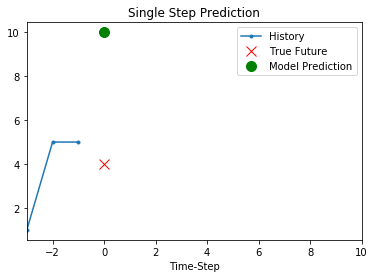

In [151]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 6].numpy(), y[0].numpy(),
                    np.argmax(probability_model.predict(x)[0])], 0,
                   'Single Step Prediction')
  plot.show()

# Multi-Step model

In [73]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
future_target = 2
STEP = N_STEPS+1
past_history = STEP - future_target

x_train_multi, y_train_multi = multivariate_data(dataset2, dataset2[:, 6], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
x_val_multi, y_val_multi = multivariate_data(dataset2, dataset2[:, 6],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=False)

We check that the data and label sets have the correct size

In [74]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Action to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (2, 7)

 Target Action to predict : (2,)


We prepate the chunks

In [75]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

We plot a true future

In [58]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 6]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

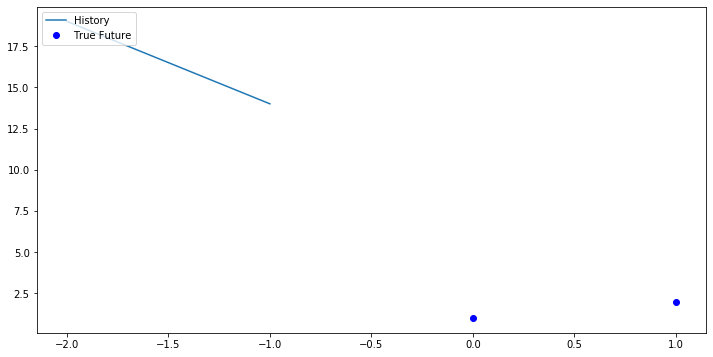

In [40]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Here is the model with 2 layers. The last layer has the number of predictions as outputs

In [102]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(N_CATEGORIES,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation='softmax'))

multi_step_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

In [104]:
multi_step_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 2, 28)             4032      
_________________________________________________________________
dense_5 (Dense)              (None, 2, 28)             812       
Total params: 4,844
Trainable params: 4,844
Non-trainable params: 0
_________________________________________________________________


This is the prediction shape, which should be (BATCHSIZE, # predicted points)

In [98]:
for x, y in val_data_multi.take(1):
  print (tf.shape(multi_step_model.predict(x)))

tf.Tensor([20  2 28], shape=(3,), dtype=int32)


We train the model

In [105]:
EPOCHS = 100

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 8.2 steps, validate for 50 steps
Epoch 1/100
9/8 [================================] - 6s 719ms/step - loss: 3.3311 - accuracy: 0.0000e+00 - val_loss: 3.3318 - val_accuracy: 0.0000e+00
Epoch 2/100
9/8 [================================] - 0s 26ms/step - loss: 3.3263 - accuracy: 0.0212 - val_loss: 3.3289 - val_accuracy: 0.0122
Epoch 3/100
9/8 [================================] - 0s 19ms/step - loss: 3.3205 - accuracy: 0.1121 - val_loss: 3.3252 - val_accuracy: 0.2320
Epoch 4/100
9/8 [================================] - 0s 27ms/step - loss: 3.3130 - accuracy: 0.3758 - val_loss: 3.3202 - val_accuracy: 0.2320
Epoch 5/100
9/8 [================================] - 0s 25ms/step - loss: 3.3028 - accuracy: 0.3758 - val_loss: 3.3131 - val_accuracy: 0.2443
Epoch 6/100
9/8 [================================] - 0s 26ms/step - loss: 3.2884 - accuracy: 0.3636 - val_loss: 3.3027 - val_accuracy: 0.2443
Epoch 7/100
9/8 [================================] - 0s 22ms/step - loss: 3.2681 - accuracy: 0.3

In [124]:
test_loss, test_acc = multi_step_model.evaluate(x_val_multi,  y_val_multi, verbose=2)

print('\nTest accuracy:', test_acc)

41/41 - 3s - loss: 3.0832 - accuracy: 0.3293

Test accuracy: 0.3292683


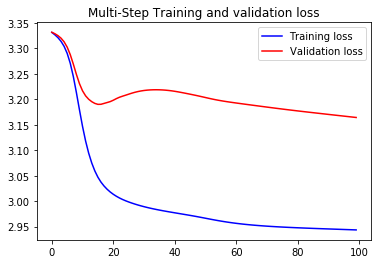

In [106]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [134]:
hist = pd.DataFrame(multi_step_history.history)
hist['epoch'] = multi_step_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,2.944281,0.448485,3.167033,0.329741,95
96,2.944069,0.448485,3.166365,0.329741,96
97,2.943858,0.448485,3.165696,0.329741,97
98,2.943646,0.448485,3.165026,0.329741,98
99,2.943434,0.448485,3.164351,0.329741,99


In [135]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Accuracy [Action]')

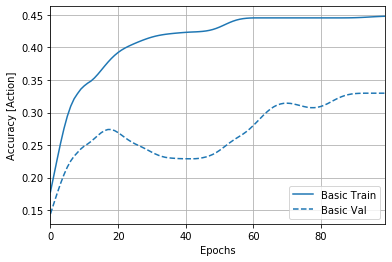

In [137]:
plotter.plot({'Basic': multi_step_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

In [138]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])





Epoch: 0, accuracy:0.4485,  loss:2.9432,  val_accuracy:0.3420,  val_loss:3.1637,  
................................................................................................

Text(0, 0.5, 'Accuracy [Action]')

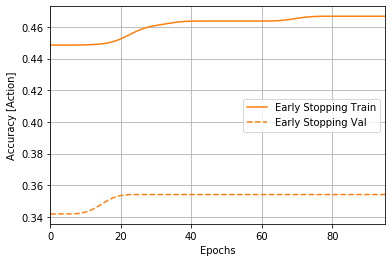

In [139]:
plotter.plot({'Early Stopping': early_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

let's check the predictions

In [125]:
probability_multi_model = tf.keras.Sequential([multi_step_model, 
                                         tf.keras.layers.Softmax()])

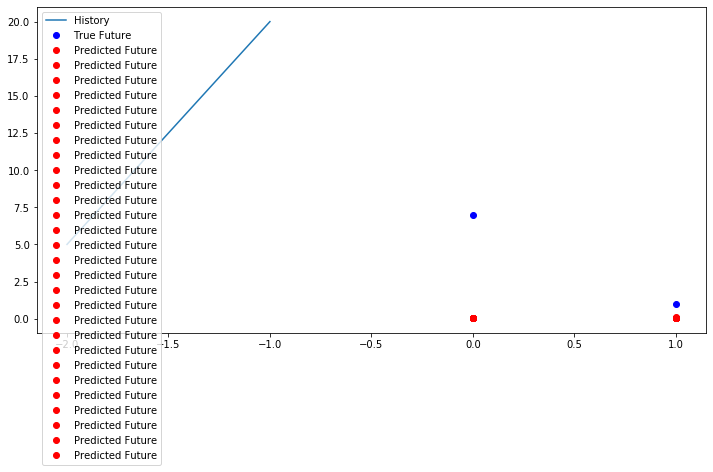

In [126]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], probability_multi_model.predict(x)[0])